Stem tokens (using Porter stemmer) and insert tokens from docs into inverted index

In [1]:
import os

import nltk
from InvertedIndex import InvertedIndex  # Custom library
from ModelResults import ModelResults
from nltk.stem import PorterStemmer
from VectorSpace import VectorSpace

docs_path = "../Dataset/docs/"
docs_list = os.listdir(docs_path)

# Used later for query preprocessing
removed_frequent_words = []
replaced_words = {}

invertedIndex = InvertedIndex()
ps = PorterStemmer()

for doc_name in docs_list:
    file_path = os.path.join(docs_path, doc_name)
    doc = open(file_path)
    for token in doc:
        invertedIndex.insert(ps.stem(token[:-1].lower()), doc_name)
    doc.close()

Filter inverted tokens words using stopwords and replace tokens with synonyms

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
stopwords = stopwords.words("english")

for word in stopwords:
    invertedIndex.delete(ps.stem(word))

[nltk_data] Downloading package stopwords to /home/greg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Plot token frequency distribution in filtered inverted index

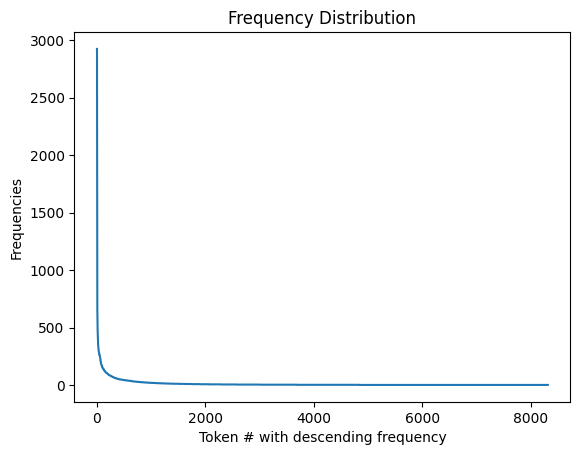

In [3]:
import operator

import matplotlib.pyplot as plt


def plotFrequencyDistribution():
    tokenFrequencies = {}
    for token, data in invertedIndex.getTokens():
        tokenFrequencies[token] = invertedIndex.countOccurances(token)
    tokenFrequencies = dict(
        sorted(tokenFrequencies.items(), key=operator.itemgetter(1), reverse=True)
    )
    plt.plot(
        range(len(list(tokenFrequencies.values()))), list(tokenFrequencies.values())
    )
    plt.title("Frequency Distribution")
    plt.xlabel("Token # with descending frequency")
    plt.ylabel("Frequencies")
    plt.show()
    return tokenFrequencies


tokenFrequencies = plotFrequencyDistribution()

As you can see, very few tokens are very frequent and the rest is very infrequent.

Thus I decided to remove very frequet tokens, that appear on mostly every document, since I don't want the information retrieval system to focus on those when computing answers to queries.

I also replaced infrequent tokens with synonyms, hoping that the synonyms would have a higher frequency in the docs, so that by doing the same replacements in the query tokens the answers of the infrequent tokens will be grouped with their synonyms.

I set the thresholds for the frequent token removal and the infrequent token replacement so that when later plotting the Frequency Distribution graph again, I will only have the "knee" of the currrent graph. This is an emperical rule to make sure that we don't have many very frequent or very infrequent tokens in the inverted index

In [4]:
from nltk.corpus import wordnet

nltk.download("wordnet")

# Remove frequent tokens
for token, frequency in tokenFrequencies.items():
    if frequency > 100:
        invertedIndex.delete(token)
        removed_frequent_words.append(token)
    else:
        break

# Replace infrequent words with synonyms
for token, frequency in reversed(tokenFrequencies.items()):
    if frequency < 15:
        synonyms = wordnet.synsets(token)
        for synonym in synonyms:
            new_token = ps.stem(synonym.lemmas()[0].name())  # type: ignore
            if (
                new_token != token
                and "_" not in new_token
                and new_token in invertedIndex.getTokens()
            ):
                replaced_words[token] = new_token
                invertedIndex.rename(token, new_token)
                break
    else:
        break

[nltk_data] Downloading package wordnet to /home/greg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now i plot the frequency distribution again in order to evaluate what it looks like

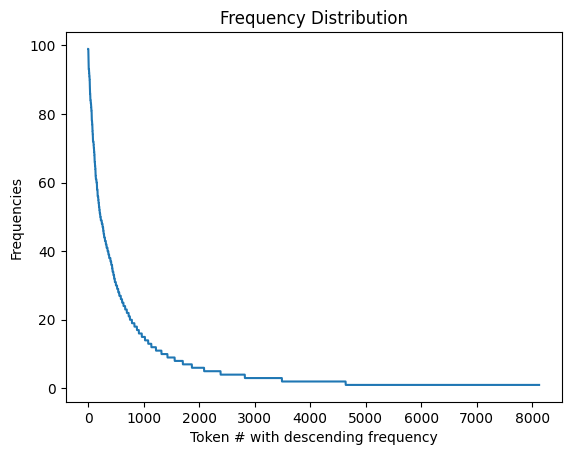

In [5]:
tokenFrequencies = plotFrequencyDistribution()

It is visible now that we are left with the "knee" of the original frequency distribution, so all very frequent and all very infrequent tokens are removed.
Now let's enter the documents and queries into the Vector Space Model:

In [6]:
with open("../Dataset/Queries_20") as queries:
    vectorSpace = VectorSpace(
        documents=docs_list,
        queries=queries,
        invertedIndex=invertedIndex,
        document_tf_weighting=VectorSpace.tf_simplefrequency,
        document_idf_weighting=VectorSpace.idf_logsimple,
        document_normalize_function=VectorSpace.cosine_normalization,
        query_tf_weighting=VectorSpace.tf_doublehalfnormalization,
        query_idf_weighting=VectorSpace.idf_logsimple,
        query_normalize_function=VectorSpace.no_normalization,
        query_stopwords=stopwords,
        query_removed_frequent_words=removed_frequent_words,
        query_replaced_words=replaced_words,
        query_stemmer=ps,
    )

In [7]:
vectorSpaceResults = [vectorSpace.lookup(str(i), 20) for i in range(20)]

In [8]:
import csv
import os

docs_path = "../Dataset/docs/"
docs_list = sorted(os.listdir(docs_path))
queries = "../Dataset/Queries_20"
relevant = "../Dataset/cfquery_detailed"

previous_doc_name = 0
count = 0
missing = []
for doc_name in docs_list:
    if (int(doc_name) - int(previous_doc_name)) != 1:
        for i in range(1, int(doc_name) - int(previous_doc_name)):
            missing.append(int(doc_name) - i)
        count += 1
    previous_doc_name = doc_name
print(f"Missing count: {count}")
print(f"Missing {missing}")

Missing count: 28
Missing [129, 132, 200, 213, 219, 282, 296, 343, 397, 465, 489, 492, 491, 508, 507, 513, 537, 627, 724, 902, 926, 940, 1013, 1033, 1103, 1134, 1138, 1184, 1190, 1225]


Because ColBERT needs incremental cids, I create a dictionary mapping incremental cids to doc ids

In [9]:
cid_dictionary = {}
i = 0
for doc_name in docs_list:
    cid_dictionary[doc_name.lstrip("0")] = i
    i += 1

inverted_cid_dictionary = {v: k for k, v in cid_dictionary.items()}

Preprocess the data into Tab Separated Values (TSV)

In [10]:
import operator


def processRelevantIntoRanking(relevant_string, query_id):
    relevant_string = relevant_string.split()
    relevant_order = {}
    flag = False
    for text in relevant_string:
        if not flag:
            if text in cid_dictionary:
                doc_id = cid_dictionary[text]
                flag = True
            else:
                continue
        else:
            score = 0
            for digit in text:
                score += int(digit)
            score /= len(text)
            relevant_order[doc_id] = score
            flag = False
    relevant_order = dict(
        sorted(relevant_order.items(), key=operator.itemgetter(1), reverse=True)
    )
    i = 1
    for doc_id in relevant_order:
        relevant_order[doc_id] = i
        i += 1
    return relevant_order

In [11]:
import csv
import os

docs_path = "../Dataset/docs/"
docs_list = sorted(os.listdir(docs_path))
queries = "../Dataset/Queries_20"
relevant = "../Dataset/cfquery_detailed"

with open("../Dataset/TSVs/collection.tsv", "w", newline="") as collectiontsv:
    for doc_name in docs_list:
        file_path = os.path.join(docs_path, doc_name)
        doc = open(file_path)
        collectiontsv.write(str(cid_dictionary[doc_name.lstrip("0")]) + "\t")
        for token in doc:
            collectiontsv.write(token[:-1].lower() + " ")
        collectiontsv.write("\n")

# Correct missing query (Queries_20 has only 19 out of queries)
"""
with open("../Dataset/Queries_20", "r") as queries:
    line_count = len(queries.readlines())
    if line_count < 20:
        write_missing_query = open("../Dataset/Queries_20", "a")
        write_missing_query.write(
            "What is the effect of treatment of CF patients with essential fatty acid supplements?\n"
        )
        write_missing_query.close()
    queries.close()
"""

with open("../Dataset/TSVs/queries.tsv", "w", newline="") as queriestsv:
    i = 1
    queries = open("../Dataset/Queries_20", "r")
    for query in queries:
        queriestsv.write(str(i) + "\t")
        queriestsv.write(query)
        i += 1

with open("../Dataset/TSVs/relevant.tsv", "w", newline="") as relevanttsv:
    relevant = open(relevant)
    relevant_per_query = ""
    flag = False
    i = 1
    for line in relevant:
        if flag == False and line[0:2] == "RD":
            flag = True
            relevant_per_query += line[3:]
        elif flag == True and line[0:2] == "QN":
            flag = False
            relevant_order = processRelevantIntoRanking(relevant_per_query, i)
            for doc_id in relevant_order:
                relevanttsv.write(
                    str(i)
                    + "\t"
                    + str(doc_id)
                    + "\t"
                    + str(relevant_order[doc_id])
                    + "\n"
                )
            i += 1
            relevant_per_query = ""
        elif flag == True:
            relevant_per_query += line

Import ColBERT libraries

In [12]:
import os
import sys

sys.path.insert(0, "../ColBERT/")
import colbert
from colbert import Indexer, Searcher
from colbert.data import Collection, Queries
from colbert.infra import ColBERTConfig, Run, RunConfig

sys.path.insert(0, "../Code/")

Compute Indexes

In [13]:
nbits = 8
with Run().context(
    RunConfig(nranks=1, experiment="../../ColBERT/experiments/cystic_fibrosis")
):
    config = ColBERTConfig(
        nbits=nbits,
        root="../ColBERT/experiments",
    )
    indexer = Indexer(checkpoint="../ColBERT/models/colbertv2.0", config=config)
    indexer.index(
        name="cystic_fibrosis.nbits=" + str(nbits),
        collection="../Dataset/TSVs/collection.tsv",
        overwrite=True,
    )



[Dec 30, 00:28:53] #> Note: Output directory /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/indexes/cystic_fibrosis.nbits=8 already exists


[Dec 30, 00:28:53] #> Will delete 10 files already at /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/indexes/cystic_fibrosis.nbits=8 in 20 seconds...
#> Starting...
nranks = 1 	 num_gpus = 1 	 device=0
{
    "query_token_id": "[unused0]",
    "doc_token_id": "[unused1]",
    "query_token": "[Q]",
    "doc_token": "[D]",
    "ncells": null,
    "centroid_score_threshold": null,
    "ndocs": null,
    "load_index_with_mmap": false,
    "index_path": null,
    "nbits": 8,
    "kmeans_niters": 20,
    "resume": false,
    "similarity": "cosine",
    "bsize": 64,
    "accumsteps": 1,
    "lr": 1e-5,
    "maxsteps": 400000,
    "save_every": null,
    "warmup": 20000,
    "warmup_bert": null,
    "relu": false,
    "nway": 64,
    "use_ib_ne

0it [00:00, ?it/s]

[Dec 30, 00:33:25] [0] 		 #> Saving chunk 0: 	 1,209 passages and 185,540 embeddings. From #0 onward.


1it [02:03, 123.95s/it]
100%|██████████| 4096/4096 [00:00<00:00, 144022.51it/s]


[Dec 30, 00:33:26] [0] 		 #> Checking all files were saved...
[Dec 30, 00:33:26] [0] 		 Found all files!
[Dec 30, 00:33:26] [0] 		 #> Building IVF...
[Dec 30, 00:33:26] [0] 		 #> Loading codes...
[Dec 30, 00:33:26] [0] 		 Sorting codes...
[Dec 30, 00:33:26] [0] 		 Getting unique codes...
[Dec 30, 00:33:26] #> Optimizing IVF to store map from centroids to list of pids..
[Dec 30, 00:33:26] #> Building the emb2pid mapping..
[Dec 30, 00:33:26] len(emb2pid) = 185540
[Dec 30, 00:33:26] #> Saved optimized IVF to /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/indexes/cystic_fibrosis.nbits=8/ivf.pid.pt
[Dec 30, 00:33:26] [0] 		 #> Saving the indexing metadata to /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/indexes/cystic_fibrosis.nbits=8/metadata.json ..
#> Joined...


Retrieve information

In [14]:
with Run().context(
    RunConfig(nranks=1, experiment="../../ColBERT/experiments/cystic_fibrosis")
):
    config = ColBERTConfig(
        root="../ColBERT/experiments",
    )
    searcher = Searcher(index="cystic_fibrosis.nbits=" + str(nbits), config=config)
    queries = Queries("../Dataset/TSVs/queries.tsv")
    ranking = searcher.search_all(queries, k=20)
    ranking.save("cystic_fibrosis.nbits=" + str(nbits) + ".ranking.tsv")

colbertResults = []
i = 0
for query in ranking.data:
    colbertResults.append([])
    for answer in ranking.data[query]:
        colbertResults[i].append(inverted_cid_dictionary[answer[0]].strip("0"))
    i += 1

[Dec 30, 00:33:26] #> Loading collection...
0M 
[Dec 30, 00:33:28] #> Loading codec...
[Dec 30, 00:33:28] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Dec 30, 00:33:28] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Dec 30, 00:33:28] #> Loading IVF...
[Dec 30, 00:33:28] #> Loading doclens...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]

[Dec 30, 00:33:28] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.48it/s]

[Dec 30, 00:33:28] #> Loading the queries from ../Dataset/TSVs/queries.tsv ...
[Dec 30, 00:33:28] #> Got 20 queries. All QIDs are unique.


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What are the effects of calcium on the physical properties of mucus from CF patients, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2024,  1996,  3896,  1997, 13853,  2006,  1996,
         3558,  5144,  1997, 14163,  7874,  2013, 12935,  5022,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])




20it [00:00, 87.85it/s]




[Dec 30, 00:33:30] #> Creating directory /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/none/2023-12/30/00.28.52 


[Dec 30, 00:33:30] #> Saved ranking of 20 queries and 400 lines to /home/greg/University-Information-Retrieval/Code/experiments/../../ColBERT/experiments/cystic_fibrosis/none/2023-12/30/00.28.52/cystic_fibrosis.nbits=8.ranking.tsv


Calculate the correct answers from the dataset

In [15]:
correctAnswers = []


def processRelevant(relevant_string):
    relevant_string = relevant_string.split()
    relevant = {}
    flag = False
    for text in relevant_string:
        if not flag:
            doc_id = text
            flag = True
        else:
            score = 0
            for digit in text:
                score += int(digit)
            relevant[doc_id] = score  # type: ignore
            flag = False
    relevant = dict(sorted(relevant.items(), key=lambda item: item[1], reverse=True))
    return relevant


with open("../Dataset/cfquery_detailed", "r") as relevant:
    relevant_per_query = ""
    flag = False
    for line in relevant:
        if flag is False and line[0:2] == "RD":
            flag = True
            relevant_per_query += line[3:]
        elif flag is True and line[0:2] == "QN":
            flag = False
            correctAnswers.append(processRelevant(relevant_per_query))
            relevant_per_query = ""
        elif flag is True:
            relevant_per_query += line

Create ModelResults objects to compute metrics and gain ability to view and plot them

In [16]:
vectorSpaceResults = ModelResults(vectorSpaceResults, correctAnswers, "Vector Space")
colbertResults = ModelResults(colbertResults, correctAnswers, "ColBERT")

Printing average precision, recall and DCG metrics

In [17]:
print(f"Vector Space Mean Precision: {vectorSpaceResults.getMeanPrecision()}")
print(f"ColBERT Mean Precision: {colbertResults.getMeanPrecision()}")

Vector Space Mean Precision: [0.9526315789473682, 0.9105263157894737, 0.8605263157894736, 0.8157894736842107, 0.7710526315789474, 0.7210526315789473, 0.6815789473684212, 0.6315789473684209, 0.5815789473684211, 0.5342105263157894, 0.4842105263157894, 0.43421052631578955, 0.3842105263157894, 0.3342105263157894, 0.28421052631578947, 0.23421052631578948, 0.1894736842105263, 0.13947368421052633, 0.08947368421052634, 0.039473684210526314]
ColBERT Mean Precision: [0.9789473684210526, 0.957894736842105, 0.9289473684210524, 0.9, 0.8605263157894738, 0.8210526315789473, 0.7894736842105262, 0.7552631578947369, 0.7157894736842105, 0.6868421052631579, 0.6526315789473683, 0.6157894736842104, 0.5763157894736842, 0.5368421052631578, 0.4921052631578947, 0.4526315789473684, 0.4131578947368421, 0.37368421052631584, 0.3289473684210527, 0.2842105263157896]


In [18]:
print(f"Vector Space Mean Recall: {vectorSpaceResults.getMeanRecall()}")
print(f"ColBERT Mean Recall: {colbertResults.getMeanRecall()}")

Vector Space Mean Recall: [0.0004017677782241864, 0.0020528710163101485, 0.0020528710163101485, 0.002851341551622789, 0.003545506990665689, 0.003545506990665689, 0.007493897781161743, 0.007493897781161743, 0.007493897781161743, 0.007895665559385928, 0.007895665559385928, 0.007895665559385928, 0.007895665559385928, 0.007895665559385928, 0.007895665559385928, 0.007895665559385928, 0.010490415793750464, 0.010490415793750464, 0.010490415793750464, 0.010490415793750464]
ColBERT Mean Recall: [0.026887079052577145, 0.053487560397935965, 0.0652200245435762, 0.08165951025382316, 0.09279822533990666, 0.10156684046906632, 0.1101890427835145, 0.11932474696397376, 0.1250172766119072, 0.13836084894760303, 0.15065084889269714, 0.15624228424448985, 0.1643048707361643, 0.17073058296683008, 0.17224697083572713, 0.17629041857142078, 0.18336995674031023, 0.1919877132528036, 0.1932370487126654, 0.20037990585552254]


In [19]:
print(f"Vector Space Mean DCG: {vectorSpaceResults.getMeanDCG()}")
print(f"ColBERT Mean DCG: {colbertResults.getMeanDCG()}")

Vector Space Mean DCG: [0.05263157894736842, 0.2631578947368421, 0.16603414567669936, 0.29354338862782337, 0.23168541415416824, 0.08962815286083736, 0.34771566590045727, 0.11590522196681909, 0.03656402656658512, 0.06363844770616522, 0.01839563683332264, 0.005131333125415441, 0.001386681993564039, 0.0003642113808540434, 9.322282565665639e-05, 2.3305706414164097e-05, 0.15790043859581396, 0.03786649365185193, 0.008914110123587166, 0.0020625308723049188]
ColBERT Mean DCG: [3.9473684210526314, 6.7894736842105265, 6.546838853195685, 4.641840479229422, 2.6307108280886977, 1.754539974131576, 2.7828744856960963, 2.032887986460102, 1.2202521265888768, 1.3673324923760135, 1.5531424662695825, 0.8542907661360454, 1.1255988020901688, 0.8219537914810893, 0.8419646163208597, 1.2631227330275834, 0.8879710298181063, 1.1603149439543556, 0.694201111698314, 0.4237809075351163]


Displaying comparison precision recall curve

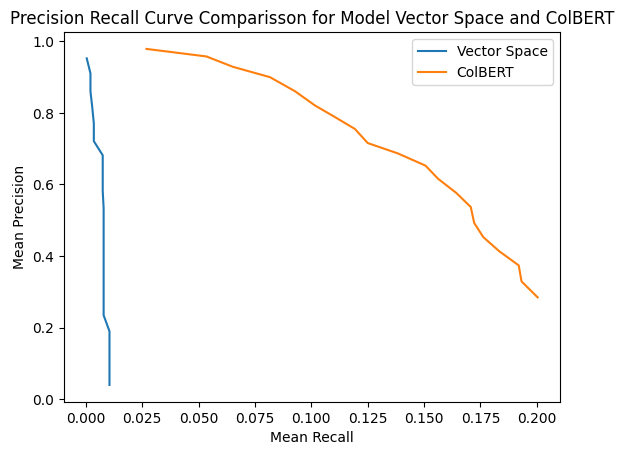

In [20]:
vectorSpaceResults.compare_mean_precision_recall_curve(colbertResults)

Displaying comparison DCG curve

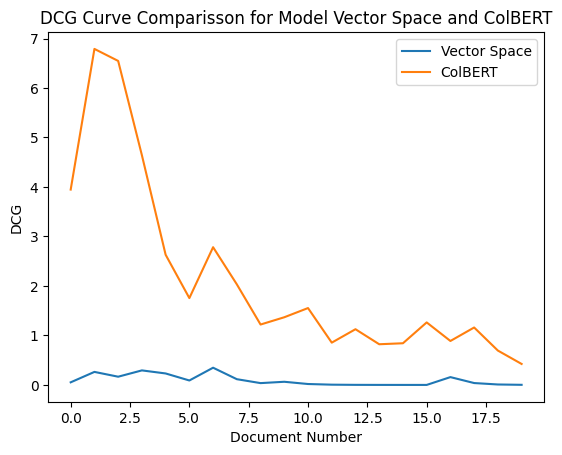

In [21]:
vectorSpaceResults.compare_mean_dcg_curve(colbertResults)